In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.max_colwidth',None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/books-dataset/books_data/ratings.csv
/kaggle/input/books-dataset/books_data/users.csv
/kaggle/input/books-dataset/books_data/books.csv


In [2]:
users_df = pd.read_csv('/kaggle/input/books-dataset/books_data/users.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv('/kaggle/input/books-dataset/books_data/ratings.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("/kaggle/input/books-dataset/books_data/books.csv",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

In [3]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [4]:
books_df.shape

(271360, 8)

# **Pre-Processing**

In [5]:
drop_indeces = users_df[users_df['Location'].str.split(',').str.len()!=3].index

In [6]:
users_cont_df = users_df.drop(index = drop_indeces)

In [7]:
(users_cont_df['Location'].str.split(",").str.len()==3).value_counts()

Location
True    277348
Name: count, dtype: int64

In [8]:
users_cont_df[['City','State','Country']] = users_cont_df['Location'].str.strip().str.split(",",expand=True,n=2)

In [9]:
users_cont_df['City'] = users_cont_df['City'].str.strip()
users_cont_df['State'] = users_cont_df['State'].str.strip()
users_cont_df['Country'] = users_cont_df['Country'].str.strip()

In [10]:
users_cont_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


In [11]:
users_cont_df = users_cont_df.drop('Location', axis=1)

In [12]:
users_cont_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [13]:
users_cont_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [14]:
users_cont_df[~users_cont_df['Age'].between(10,90) & ~users_cont_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

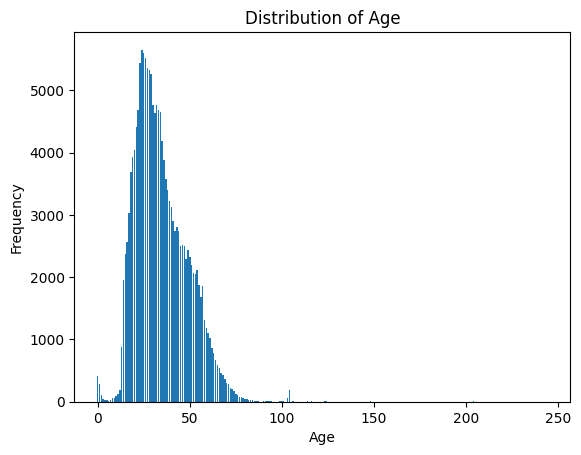

In [15]:
ages_graph = users_cont_df.groupby('Age').size()
plt.bar(ages_graph.index, ages_graph.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

In [16]:
users_to_omit = ~users_cont_df['Age'].between(10,90) & ~users_cont_df['Age'].isnull()
users_cont_df.loc[users_to_omit] = np.nan
users_cont_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

In [17]:
users_cont_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [18]:
users_cont_df['Age'].mean()

34.729518290474466

In [19]:
null_age = users_cont_df['Age'].isnull()
users_cont_df.loc[null_age,'Age'] = users_cont_df['Age'].mean()

<BarContainer object of 82 artists>

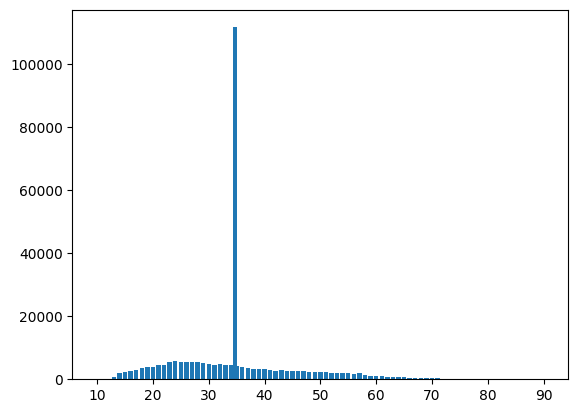

In [20]:
ages_graph = users_cont_df.groupby('Age').size()
plt.bar(ages_graph.index, ages_graph.values)

In [21]:
users_cont_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [22]:
users_cont_df['Age'] = users_cont_df['Age'].astype('int')

In [23]:
users_cont_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

In [24]:
users_cont_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

In [25]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [26]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [27]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

In [28]:
users_cont_df = users_cont_df[users_cont_df['Country'].isin(list_of_countries)]
users_cont_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


In [29]:
list_of_states = users_cont_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [30]:
list_of_states

array([nan, 'hants', 'ontario', ..., 'nordtrondelag', 'hedehusene',
       'sulawesi'], dtype=object)

In [31]:
users_cont_df = users_cont_df[users_cont_df['State'].isin(list_of_states)]

In [32]:
list_of_city = users_cont_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_cont_df = users_cont_df[users_cont_df['City'].isin(list_of_city)]

In [33]:
print("Unique country count: " , users_cont_df['Country'].nunique())
print("Unique state count: " ,users_cont_df['State'].nunique())
print("Unique City count: " , users_cont_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


In [34]:
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.LZZZZZZZ.jpg
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.LZZZZZZZ.jpg
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.LZZZZZZZ.jpg
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.LZZZZZZZ.jpg


In [35]:
books_df['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [36]:
import re

def is_valid_year(year_str):
    """Checks if a string is a valid year (4 digits)."""
    if isinstance(year_str, str):  # Check if it's a string
        return bool(re.match(r'^\d{4}$', year_str))
    else:
        return False

In [37]:
books_cont_df = books_df[books_df['Year-Of-Publication'].apply(is_valid_year)]

In [38]:
books_cont_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [39]:
books_cont_df['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '1968', '1961', '1958', '1974',
       '1976', '1971', '1977', '1975', '1965', '1941', '1970', '1962',
       '1973', '1972', '1960', '1966', '1920', '1956', '1959', '1953',
       '1951', '1942', '1963', '1964', '1969', '1954', '1950', '1967',
       '2005', '1957', '1940', '1937', '1955', '1946', '1936', '1930',
       '2011', '1925', '1948', '1943', '1947', '1945', '1923', '2020',
       '1939', '1926', '1938', '2030', '1911', '1904', '1949', '1932',
       '1928', '1929', '1927', '1931', '1914', '2050', '1934', '1910',
       '1933', '1902', '1924', '1921', '1900', '2038', '2026', '1944',
       '1917', '1901', '2010', '1908', '1906', '1935', '1806', '2021',
       '2012', '2006', '1909', '2008', '1378', '1919', '1922', '1897',
      

In [40]:
books_cont_df.shape

(266739, 8)

In [41]:
books_cont_df['Year-Of-Publication'] = books_cont_df['Year-Of-Publication'].astype('int')

/tmp/ipykernel_34/2600325888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_cont_df['Year-Of-Publication'] = books_cont_df['Year-Of-Publication'].astype('int')


In [42]:
books_cont_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

In [43]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
sorted(ratings_df['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Text(0, 0.5, 'Frequency')

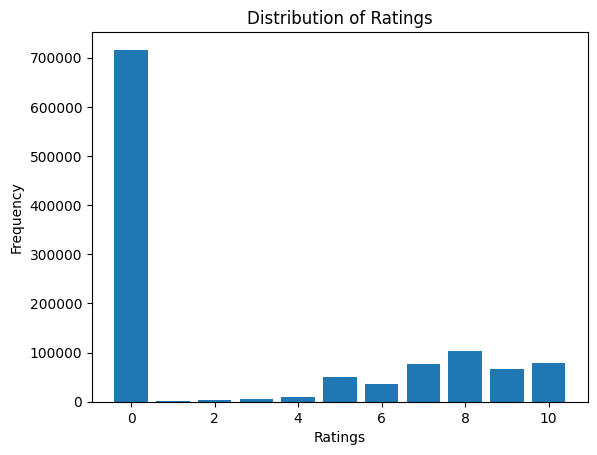

In [45]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

In [46]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [47]:
books_cont_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
 5   Image-URL-S          266739 non-null  object
 6   Image-URL-M          266739 non-null  object
 7   Image-URL-L          266739 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.3+ MB


In [48]:
users_cont_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int64  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.2+ MB


In [49]:
content_dataset = ratings_df.merge(books_cont_df,on = 'ISBN').merge(users_cont_df,how='inner',on='User-ID')
content_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int64 
 6   Publisher            132920 non-null  object
 7   Image-URL-S          132920 non-null  object
 8   Image-URL-M          132920 non-null  object
 9   Image-URL-L          132920 non-null  object
 10  Age                  132920 non-null  int64 
 11  City                 132920 non-null  object
 12  State                132920 non-null  object
 13  Country              132920 non-null  object
dtypes: int64(4), object(10)
memory usage: 14.2+ MB


In [50]:
content_dataset.drop(columns=['Image-URL-S', 'Image-URL-L'], inplace=True)

In [51]:
content_dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,Age,City,State,Country
0,276774,0099543818,0,"East, West",Salman Rushdie,1995,Vintage Books,http://images.amazon.com/images/P/0099543818.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
1,276774,3404147723,0,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,Patrice Leavold,2002,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404147723.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
2,276774,3423111321,0,Die Teufelin. Roman.,Fay Weldon,1989,Dtv,http://images.amazon.com/images/P/3423111321.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
3,276774,3442136644,9,Endlich Nichtraucher.,Allen Carr,1992,Goldmann,http://images.amazon.com/images/P/3442136644.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
4,276774,3492232000,0,Ein Liebhaber zuviel ist noch zu wenig.,Gaby Hauptmann,2000,Piper,http://images.amazon.com/images/P/3492232000.01.MZZZZZZZ.jpg,28,bern,bern,switzerland


In [52]:
content_dataset = content_dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
content_dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,Age,City,State,Country
0,276774,0099543818,0,"East, West",Salman Rushdie,1995,Vintage Books,http://images.amazon.com/images/P/0099543818.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
1,276774,3404147723,0,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,Patrice Leavold,2002,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404147723.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
2,276774,3423111321,0,Die Teufelin. Roman.,Fay Weldon,1989,Dtv,http://images.amazon.com/images/P/3423111321.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
3,276774,3442136644,9,Endlich Nichtraucher.,Allen Carr,1992,Goldmann,http://images.amazon.com/images/P/3442136644.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
4,276774,3492232000,0,Ein Liebhaber zuviel ist noch zu wenig.,Gaby Hauptmann,2000,Piper,http://images.amazon.com/images/P/3492232000.01.MZZZZZZZ.jpg,28,bern,bern,switzerland


In [53]:
recomendation_cont_dataset = content_dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_cont_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int64 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int64 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.1+ MB


In [54]:
encoder = LabelEncoder()
for column in recomendation_cont_dataset.columns:
    if recomendation_cont_dataset[column].dtype == object:
        recomendation_cont_dataset[column] = encoder.fit_transform(recomendation_cont_dataset[column])

In [55]:
recomendation_cont_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,27839,1995,6288,28,261,81,79
1,0,23900,2002,3634,28,261,81,79
2,0,9455,1989,1697,28,261,81,79
3,9,1009,1992,2420,28,261,81,79
4,0,10235,2000,4671,28,261,81,79
...,...,...,...,...,...,...,...,...
132915,0,21284,1997,3025,30,2545,496,16
132916,0,15027,2000,1328,30,2545,496,16
132917,5,15481,1999,5995,34,1830,264,87
132918,5,21118,2000,5995,34,1830,264,87


In [56]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [57]:
for column in recomendation_cont_dataset.columns:
    min = recomendation_cont_dataset[column].min()
    max = recomendation_cont_dataset[column].max()
    recomendation_cont_dataset[column] = recomendation_cont_dataset[column].apply(normalizer,args=(min,max))

In [58]:
recomendation_cont_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132
...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044


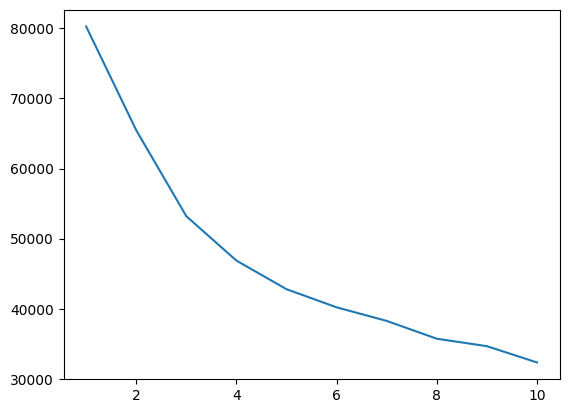

In [59]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_cont_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)

In [60]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_cont_dataset)

In [61]:
recomendation_cont_dataset['Clusters'] = clusters

In [62]:
recomendation_cont_dataset['Clusters'].value_counts()

Clusters
0    27092
1    27052
3    26505
2    26330
4    25941
Name: count, dtype: int64

In [63]:
recomendation_cont_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132,0
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132,0
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132,0
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132,1
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132,0
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824,3
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824,3
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044,1
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044,1


In [64]:
X,y = recomendation_cont_dataset.iloc[:,:-1],recomendation_cont_dataset.iloc[:,-1]

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [66]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(X_train,y_train)

NearestCentroid()

In [67]:
print(cross_val_score(rocchio_clf,X_test,y_test,cv=5))

[0.99830732 0.99811924 0.99811924 0.99849539 0.99642588]


In [68]:
pred_y = rocchio_clf.predict(X_test)

In [69]:
accuracy_score(y_test,pred_y)

0.9993981342160698

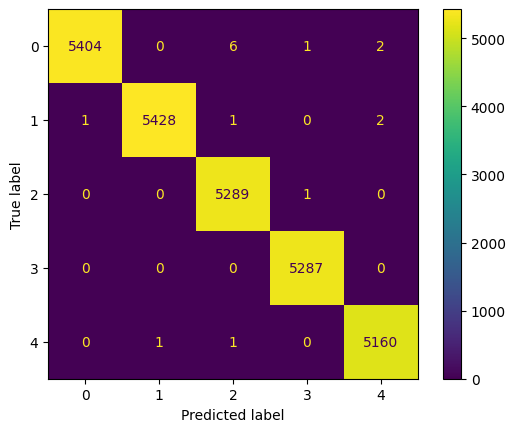

In [70]:
cm = confusion_matrix(y_test,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# **Collaborative Filtering**

In [71]:
ratings_w_name = ratings_df.merge(books_df, on='ISBN')

In [72]:
ratings_w_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0155061224.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0155061224.01.LZZZZZZZ.jpg
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/052165615X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/052165615X.01.LZZZZZZZ.jpg
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0521795028.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0521795028.01.LZZZZZZZ.jpg


In [73]:
X = ratings_w_name.groupby('User-ID').count()['Book-Rating']>200
active_users = X[X].index

In [74]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [75]:
active_users

Index([   254,   2276,   2766,   2977,   3363,   4017,   4385,   6251,   6323,
         6543,
       ...
       271705, 273979, 274004, 274061, 274301, 274308, 275970, 277427, 277639,
       278418],
      dtype='int64', name='User-ID', length=811)

In [76]:
filtered_rating = ratings_w_name[ratings_w_name['User-ID'].isin(active_users)]
filtered_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/002542730X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg
1151,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0026217457.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0026217457.01.LZZZZZZZ.jpg
1152,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,http://images.amazon.com/images/P/003008685X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/003008685X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/003008685X.01.LZZZZZZZ.jpg
1153,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0030615321.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0030615321.01.LZZZZZZZ.jpg
1154,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,http://images.amazon.com/images/P/0060002050.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060002050.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060002050.01.LZZZZZZZ.jpg


In [77]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [78]:
final_rating = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]
final_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/002542730X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg
1163,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.LZZZZZZZ.jpg
1165,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060934417.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060934417.01.LZZZZZZZ.jpg
1168,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Paperback)),Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0061009059.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0061009059.01.LZZZZZZZ.jpg
1174,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,http://images.amazon.com/images/P/006440188X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006440188X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006440188X.01.LZZZZZZZ.jpg


In [79]:
pivots = final_rating.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')
pivots.fillna(0, inplace=True)

In [80]:
pivots.shape

(706, 810)

In [81]:
pivots

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
similarity_collab = cosine_similarity(pivots)
similarity_collab.shape

(706, 706)

In [83]:
similarity_collab

array([[1.        , 0.10255025, 0.01220856, ..., 0.12110367, 0.07347567,
        0.04316046],
       [0.10255025, 1.        , 0.2364573 , ..., 0.07446129, 0.16773875,
        0.14263397],
       [0.01220856, 0.2364573 , 1.        , ..., 0.04558758, 0.04938579,
        0.10796119],
       ...,
       [0.12110367, 0.07446129, 0.04558758, ..., 1.        , 0.07085128,
        0.0196177 ],
       [0.07347567, 0.16773875, 0.04938579, ..., 0.07085128, 1.        ,
        0.10602962],
       [0.04316046, 0.14263397, 0.10796119, ..., 0.0196177 , 0.10602962,
        1.        ]])

In [84]:
content_dataset

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,Age,City,State,Country
0,276774,0099543818,0,"East, West",Salman Rushdie,1995,Vintage Books,http://images.amazon.com/images/P/0099543818.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
1,276774,3404147723,0,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,Patrice Leavold,2002,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404147723.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
2,276774,3423111321,0,Die Teufelin. Roman.,Fay Weldon,1989,Dtv,http://images.amazon.com/images/P/3423111321.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
3,276774,3442136644,9,Endlich Nichtraucher.,Allen Carr,1992,Goldmann,http://images.amazon.com/images/P/3442136644.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
4,276774,3492232000,0,Ein Liebhaber zuviel ist noch zu wenig.,Gaby Hauptmann,2000,Piper,http://images.amazon.com/images/P/3492232000.01.MZZZZZZZ.jpg,28,bern,bern,switzerland
...,...,...,...,...,...,...,...,...,...,...,...,...
132915,276670,1895837405,0,Dying for Veronica: A Sub-Catholic Dream With Mind-Music : A Novel,Matthew D. Remski,1997,Insomniac Press,http://images.amazon.com/images/P/1895837405.01.MZZZZZZZ.jpg,30,toronto,ontario,canada
132916,276670,1896951236,0,The Textbook of the Rose: A Tale,Joann McCaig,2000,Cormorant Books,http://images.amazon.com/images/P/1896951236.01.MZZZZZZZ.jpg,30,toronto,ontario,canada
132917,276672,0099245027,5,The Testament,John Grisham,1999,Trafalgar Square,http://images.amazon.com/images/P/0099245027.01.MZZZZZZZ.jpg,34,newport,gwent,united kingdom
132918,276672,0752834096,5,Dry Rot And Daffodils/Ne,Mary MacKie,2000,Trafalgar Square,http://images.amazon.com/images/P/0752834096.01.MZZZZZZZ.jpg,34,newport,gwent,united kingdom


In [85]:
recomendation_cont_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132,0
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132,0
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132,0
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132,1
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132,0
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824,3
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824,3
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044,1
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044,1


# **Hybrid Functions**

In [86]:
def recommend_collab(book_name):
    
    
    if book_name in pivots.index:
        index = np.where(pivots.index==book_name)[0][0]
        similar_items = sorted(list(enumerate(similarity_collab[index])),key=lambda x:x[1],reverse=True)[1:11]
    
        data = []
        for i in similar_items:
            item = {}
            temp_df = books_df[books_df['Book-Title'] == pivots.index[i[0]]]
            item['Book-Title'] = list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values)[0]
            item['Book-Author'] = list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values)[0]
            item['Image-URL-M'] = list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values)[0]
        
            data.append(item)
        return data
    
    else:
        return False

In [87]:
recommend_collab('The Da Vinci Code')

[{'Book-Title': 'Angels &amp; Demons',
  'Book-Author': 'Dan Brown',
  'Image-URL-M': 'http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Touching Evil',
  'Book-Author': 'Kay Hooper',
  'Image-URL-M': 'http://images.amazon.com/images/P/0553583441.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Saving Faith',
  'Book-Author': 'David Baldacci',
  'Image-URL-M': 'http://images.amazon.com/images/P/0446608890.01.MZZZZZZZ.jpg'},
 {'Book-Title': "The Sweet Potato Queens' Book of Love",
  'Book-Author': 'JILL CONNER BROWNE',
  'Image-URL-M': 'http://images.amazon.com/images/P/0609804138.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Middlesex: A Novel',
  'Book-Author': 'Jeffrey Eugenides',
  'Image-URL-M': 'http://images.amazon.com/images/P/0312422156.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'The Lovely Bones: A Novel',
  'Book-Author': 'Alice Sebold',
  'Image-URL-M': 'http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Timeline',
  'Book-Author': 'MICHAEL CRIC

In [88]:
def recommend_content(book_title):

    # Find the book in the dataset
    book_index = content_dataset[content_dataset['Book-Title'].str.lower() == book_title.lower()].index[0]
    book_cluster = recomendation_cont_dataset.iloc[book_index]['Clusters']
    cluster_books = recomendation_cont_dataset[recomendation_cont_dataset['Clusters'] == book_cluster]
    similarity_scores = cosine_similarity(recomendation_cont_dataset.iloc[book_index].values.reshape(1, -1), cluster_books.iloc[:, :])
    top_indices = similarity_scores.argsort()[0][-10:][::-1]
    recommended_books = cluster_books.iloc[top_indices]
    
    recommendations = []
    for index in top_indices:
        book_data = content_dataset.iloc[index]
        recommendation = {
            "Book-Title": book_data["Book-Title"],
            "Book-Author": book_data["Book-Author"],
            "Image-URL-M": book_data["Image-URL-M"]  
        }
        recommendations.append(recommendation)

    return recommendations

In [89]:
books = recommend_content('The Da Vinci Code')
books

[{'Book-Title': 'The Last Book in the Universe',
  'Book-Author': 'Rodman Philbrick',
  'Image-URL-M': 'http://images.amazon.com/images/P/0439087597.01.MZZZZZZZ.jpg'},
 {'Book-Title': "Bridget Jones's Diary",
  'Book-Author': 'Helen Fielding',
  'Image-URL-M': 'http://images.amazon.com/images/P/0330375253.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Les Miserables (Penguin Classics)',
  'Book-Author': 'Victor Hugo',
  'Image-URL-M': 'http://images.amazon.com/images/P/0140444300.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Loves Music, Loves to Dance',
  'Book-Author': 'Mary Higgins Clark',
  'Image-URL-M': 'http://images.amazon.com/images/P/0671758896.01.MZZZZZZZ.jpg'},
 {'Book-Title': "The Handmaid's Tale : A Novel",
  'Book-Author': 'Margaret Atwood',
  'Image-URL-M': 'http://images.amazon.com/images/P/038549081X.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'El Corazon Del Tartaro (Narrativa)',
  'Book-Author': 'Rosa Montero',
  'Image-URL-M': 'http://images.amazon.com/images/P/8423951537.01.MZZZZZZZ.jpg'},
 {'

In [90]:
def recommend_knn_content(book_title):

    # Find the book in the dataset
    book_index = content_dataset[content_dataset['Book-Title'].str.lower() == book_title.lower()].index[0]
    book_cluster = recomendation_cont_dataset.iloc[book_index]['Clusters']
    knn_dataset = recomendation_cont_dataset[recomendation_cont_dataset['Clusters'] == book_cluster].reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:, 1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(recomendation_cont_dataset.iloc[book_index, :-1]).T, 10, return_distance=False)[0]
    
    recommendations = []
    for neighbor in neighbors:
        neighbor_index = neighbor
        book_data = content_dataset.iloc[neighbor_index]
        recommendation = {
            "Book-Title": book_data["Book-Title"],
            "Book-Author": book_data["Book-Author"],
            "Image-URL-M": book_data["Image-URL-M"]
        }
        recommendations.append(recommendation)

    return recommendations

In [91]:
recommend_knn_content('The Da Vinci Code')


[{'Book-Title': 'The Last Book in the Universe',
  'Book-Author': 'Rodman Philbrick',
  'Image-URL-M': 'http://images.amazon.com/images/P/0439087597.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Les Miserables (Penguin Classics)',
  'Book-Author': 'Victor Hugo',
  'Image-URL-M': 'http://images.amazon.com/images/P/0140444300.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Loves Music, Loves to Dance',
  'Book-Author': 'Mary Higgins Clark',
  'Image-URL-M': 'http://images.amazon.com/images/P/0671758896.01.MZZZZZZZ.jpg'},
 {'Book-Title': "Bridget Jones's Diary",
  'Book-Author': 'Helen Fielding',
  'Image-URL-M': 'http://images.amazon.com/images/P/0330375253.01.MZZZZZZZ.jpg'},
 {'Book-Title': "The Handmaid's Tale : A Novel",
  'Book-Author': 'Margaret Atwood',
  'Image-URL-M': 'http://images.amazon.com/images/P/038549081X.01.MZZZZZZZ.jpg'},
 {'Book-Title': "Angry Housewives Eating Bon Bons (Ballantine Reader's Circle)",
  'Book-Author': 'LORNA LANDVIK',
  'Image-URL-M': 'http://images.amazon.com/images/P/03454

In [92]:
def hybrid_recommend(book_title):
    """Hybrid recommender that combines collaborative and content-based filtering."""

    collab_recs = recommend_collab(book_title)

    content_recs = recommend_content(book_title)

    knn_content_recs = recommend_knn_content(book_title)

    combined_recs = []
    if collab_recs:
        combined_recs.extend(collab_recs)
        print('colab True')

    combined_recs.extend(content_recs)

    combined_recs.extend(knn_content_recs)


    #Find the book in 'books_df' and add it to the beginning of the list
    book_info = books_df[books_df['Book-Title'].str.lower() == book_title.lower()].drop_duplicates('Book-Title')
    if not book_info.empty:
        book_data = [book_info['Book-Title'].iloc[0], book_info['Book-Author'].iloc[0], book_info['Image-URL-M'].iloc[0]]
        combined_recs.insert(0, book_data) 

    return combined_recs

In [93]:
book_to_recommend = "The Da Vinci Code"
hybrid_recommend(book_to_recommend)

colab True


[['The Da Vinci Code',
  'Dan Brown',
  'http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg'],
 {'Book-Title': 'Angels &amp; Demons',
  'Book-Author': 'Dan Brown',
  'Image-URL-M': 'http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Touching Evil',
  'Book-Author': 'Kay Hooper',
  'Image-URL-M': 'http://images.amazon.com/images/P/0553583441.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Saving Faith',
  'Book-Author': 'David Baldacci',
  'Image-URL-M': 'http://images.amazon.com/images/P/0446608890.01.MZZZZZZZ.jpg'},
 {'Book-Title': "The Sweet Potato Queens' Book of Love",
  'Book-Author': 'JILL CONNER BROWNE',
  'Image-URL-M': 'http://images.amazon.com/images/P/0609804138.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'Middlesex: A Novel',
  'Book-Author': 'Jeffrey Eugenides',
  'Image-URL-M': 'http://images.amazon.com/images/P/0312422156.01.MZZZZZZZ.jpg'},
 {'Book-Title': 'The Lovely Bones: A Novel',
  'Book-Author': 'Alice Sebold',
  'Image-URL-M': 'http://images.ama

In [94]:
def ensemble_hybrid_recommend(book_title):

    collab_recs = recommend_collab(book_title)
    content_recs = recommend_content(book_title)
    knn_content_recs = recommend_knn_content(book_title)

    combined_recs = []
    for recs in [collab_recs, content_recs, knn_content_recs]:
        if recs:  
            for rec in recs:
                combined_recs.append(rec)

    # voting_technique
    for rec in combined_recs:
        if 'count' in rec:
            rec['count'] += 1
        else:
            rec['count'] = 1

    sorted_recs = sorted(combined_recs, key=lambda item: item['count'], reverse=True)

    book_info = books_df[books_df['Book-Title'].str.lower() == book_title.lower()].drop_duplicates('Book-Title')
    if not book_info.empty:
        book_data = {
            'Book-Title': book_info['Book-Title'].iloc[0],
            'Book-Author': book_info['Book-Author'].iloc[0],
            'Image-URL-M': book_info['Image-URL-M'].iloc[0]
        }
        sorted_recs.insert(0, book_data)

    for i in range(len(sorted_recs)):
        if 'count' in sorted_recs[i]:
            del sorted_recs[i]['count']

    return sorted_recs[:10]

In [95]:
book_to_recommend = "The Da Vinci Code"
recommendations = ensemble_hybrid_recommend(book_to_recommend)
print(recommendations)

[{'Book-Title': 'The Da Vinci Code', 'Book-Author': 'Dan Brown', 'Image-URL-M': 'http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg'}, {'Book-Title': 'Angels &amp; Demons', 'Book-Author': 'Dan Brown', 'Image-URL-M': 'http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg'}, {'Book-Title': 'Touching Evil', 'Book-Author': 'Kay Hooper', 'Image-URL-M': 'http://images.amazon.com/images/P/0553583441.01.MZZZZZZZ.jpg'}, {'Book-Title': 'Saving Faith', 'Book-Author': 'David Baldacci', 'Image-URL-M': 'http://images.amazon.com/images/P/0446608890.01.MZZZZZZZ.jpg'}, {'Book-Title': "The Sweet Potato Queens' Book of Love", 'Book-Author': 'JILL CONNER BROWNE', 'Image-URL-M': 'http://images.amazon.com/images/P/0609804138.01.MZZZZZZZ.jpg'}, {'Book-Title': 'Middlesex: A Novel', 'Book-Author': 'Jeffrey Eugenides', 'Image-URL-M': 'http://images.amazon.com/images/P/0312422156.01.MZZZZZZZ.jpg'}, {'Book-Title': 'The Lovely Bones: A Novel', 'Book-Author': 'Alice Sebold', 'Image-URL-M': 'http://

In [96]:
import pickle

In [97]:
pickle.dump(books_df.to_dict(),open('book_dict.pkl','wb'))

In [98]:
pickle.dump(content_dataset,open('content_book.pkl','wb'))
pickle.dump(recomendation_cont_dataset,open('recommendation_cont_book.pkl','wb'))
pickle.dump(similarity_collab,open('similarity_score.pkl','wb'))

In [99]:
pickle.dump(pivots,open('pivots.pkl','wb'))